<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/langchain_neo4j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j openai langchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.7/187.7 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.9/922.9 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.7 MB/s eta 0:00:00

# LangChain has added Cypher Search
## With the LangChain library, you can conveniently generate Cypher queries, enabling an efficient retrieval of information from Neo4j.

If you have developed or plan to implement any solution that uses Large Language Models, you have most likely heard of the LangChain library. LangChain library is the most widely known Python library used to develop applications that use LLMs in one or another capabilities. It is designed to be modular, allowing us to use any LLM in any available modules, such as chains, tools, memory, or agents.

A month ago, I spent a week researching and implementing a solution allowing anyone to retrieve information from Neo4j directly from the LangChain library and use it in their LLM applications. I learned quite a lot about the internals of LangChain library and wrote up my experience in a blog post.

A colleague of mine showed me a LangChain feature request, where the user requested that my work of having the option to retrieve information from the Neo4j database would be added as a module directly to the LangChain library so that no additional code or external modules would be needed to integrate Neo4j into LangChain applications. Since I was already familiar with LangChain internals, I decided to try and implement Cypher searching capabilities myself. I spent a weekend researching and coding the solution and ensuring it would conform to the contribution standards for it to be added to the library. Luckily, the maintainers of LangChain are very responsive and open to new ideas, and the Cypher Search has been added in the latest release of the LangChain library. Thanks to Harrison Chase for maintaining such a great library and also being very responsive to new ideas.

In tutorial, I will show you how you can use the newly added Cypher Search in the LangChain library to retrieve information from a Neo4j database.

## What is a knowledge graph
LangChain has already integrations with Vector and SQL databases, so why do we need an integration with a Graph Database like Neo4j?
Knowledge graphs are ideal for storing heterogeneous and highly connected data. For instance, the above image contains information about people, organizations, movies, websites, etc. While the ability to intuitively model and store diverse sets of data is incredible, I think the main benefit of using graphs is the ability to analyze data points through their relationships. Graphs enable us to uncover connections and correlations that might otherwise remain unnoticed with traditional database and analytics approaches as they often overlook the context surrounding individual data points.

The power of graph databases truly shines when dealing with complex systems where interdependencies and interactions are vital in understanding the system.
They enable us to see beyond individual data points and delve into the intricate relationships that define their context. This provides a deeper, more holistic view of the data, facilitating better decision-making and knowledge discovery.

## Setting up Neo4j environment

If you have an existing Neo4j database, you can use it to try the newly added Cypher Search. The Cypher Search module uses graph schema information to generate Cypher statements, meaning you can plug it into any Neo4j database.
If you don't have any Neo4j database yet, you can use [Neo4j Sandbox](https://neo4j.com/sandbox/), which offers a free cloud instance of a Neo4j database. You need to register and instantiate any of the available pre-populated databases. I will be using the [ICIJ Paradise Papers dataset](https://sandbox.neo4j.com/?usecase=icij-paradise-papers) in this blog post, but you can use any other if you want. The dataset has been made available by International Consortium of Investigative Journalists as part of their Offshore Leaks Database.

The graph contains four types of nodes:
* Entity - The offshore legal entity. This could be a company, trust, foundation, or other legal entity created in a low-tax jurisdiction.
* Officer - A person or company who plays a role in an offshore entity, such as beneficiary, director, or shareholder. The relationships shown in the diagram are just a sample of all the existing ones.
* Intermediary - A go-between for someone seeking an offshore corporation and an offshore service provider - usually a law-firm or a middleman that asks an offshore service provider to create an offshore firm.
* Address - The registered address as it appears in the original databases obtained by ICIJ.

## Knowledge Graph Cypher Search
The name Cypher Search comes from Cypher, which is a query language used to interact with graph databases like Neo4j.

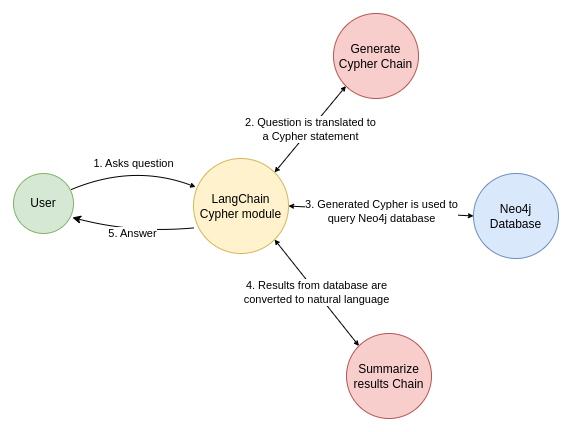

In order to allow LangChain to retrieve information from graph databases, I implemented a module that can convert the natural language to a Cypher statement, use it to retrieve data from Neo4j and return the retrieved information to the user in a natural language form. This two-way conversion process between natural language and database language not only enhances the overall accessibility of data retrieval but also greatly improves the user experience.


The beauty of the LangChain library is in its simplicity. We only need a couple of lines of code and we can retrieve information from Neo4j using natural language.

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://3.239.187.136:7687", 
    username="neo4j", 
    password="cushions-haul-revolution"
)

In [3]:
import os

os.environ['OPENAI_API_KEY'] = "sk-"

chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0), graph=graph, verbose=True,
)

Here, we are using the gpt-3.5-turbo model from OpenAI to generate Cypher statements. The Cypher statements are generated based on the graph schema, which means that, in theory, you can plug the Cypher chain into any Neo4j instance, and it should be able to answer natural language answers. Unfortunately, I haven't yet tested other LLM providers in their ability to generate Cypher statements since I don't have access to any of them. Still, I would love to hear your evaluation of other LLMs generating Cypher statements if you will give it a go. Of course, if you want to break the dependency on LLM cloud providers, you can always [fine-tune an open-source LLM to generate Cypher statements](https://towardsdatascience.com/fine-tuning-an-llm-model-with-h2o-llm-studio-to-generate-cypher-statements-3f34822ad5).

Let's start with a simple test.

In [4]:
chain.run("""
Which intermediary is connected to most entites?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (i:Intermediary)-[:CONNECTED_TO]->(e:Entity)
RETURN i.name, COUNT(e) AS num_entities
ORDER BY num_entities DESC
LIMIT 1
Full Context:
[{'i.name': 'Group - SUN Capital Partner Group', 'num_entities': 115}]

> Finished chain.


'Based on the provided information, the intermediary that is connected to the most entities is the Group - SUN Capital Partner Group, with a total of 115 entities.'

We can observe the generated Cypher statement and the retrieved information from Neo4j used to form the answer. That is as easy a setup as it gets. Let's move on to the next example.

In [5]:
chain.run("""
Who are the officers of ZZZ-MILI COMPANY LTD.?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (o:Officer)-[:OFFICER_OF]->(e:Entity{name:'ZZZ-MILI COMPANY LTD.'}) RETURN o.name
Full Context:
[{'o.name': 'Whitson - Iva Marie'}, {'o.name': 'Whitson - Claud S.'}, {'o.name': 'Whitson - Claud S.'}, {'o.name': 'FINSBURY NOMINEES LTD'}, {'o.name': 'EURO NOMINEES LTD.'}, {'o.name': 'EURO SECURITIES LTD.'}, {'o.name': 'COMPANY DIRECTORS LTD.'}]

> Finished chain.


'The officers of ZZZ-MILI COMPANY LTD. are Whitson - Iva Marie, Whitson - Claud S., FINSBURY NOMINEES LTD, EURO NOMINEES LTD., EURO SECURITIES LTD., and COMPANY DIRECTORS LTD.'

Since we are using a graph, let's construct a question that would utilize the power of graph databases.

In [ ]:
#chain_improved.run("""
#How are entities SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited related?
#""")

The generated Cypher statement looks fine at first glance. However, there is a problem as the Cypher statements used the variable-length path finding syntax and also treated relationships as undirected. As a result, this type of query is highly unoptimized and would explode in the number of rows.

The nice thing about gpt-3.5-turbo is that it follows hints and instructions we drop in the input. For example, we can ask it to find only the shortest path.

In [6]:
chain.run("""
How are entities SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited connected?
Find a shortest path.
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (e1:Entity {name: 'SOUTHWEST LAND DEVELOPMENT LTD.'}), (e2:Entity {name: 'Dragon Capital Markets Limited'})
MATCH p=shortestPath((e1)-[*]-(e2))
RETURN p
Full Context:
[{'p': [{'sourceID': 'Paradise Papers - Appleby', 'jurisdiction': 'KY', 'service_provider': 'Appleby', 'countries': 'Cayman Islands', 'jurisdiction_description': 'Cayman Islands', 'type': 'CE', 'valid_until': 'Appleby data is current through 2014', 'ibcRUC': '50843', 'labels(n)': '["Entity"]', 'name': 'SOUTHWEST LAND DEVELOPMENT LTD.', 'country_codes': 'CYM', 'incorporation_date': '1993-Oct-05', 'node_id': '82011899'}, 'REGISTERED_ADDRESS', {'sourceID': 'Paradise Papers - Appleby', 'valid_until': 'Appleby data is current through 2014', 'address': 'Clifton House', 'labels(n)': '["Address"]', 'name': 'Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands', 'country_codes': 'CYM', 'countries': 'Cayman Islands', 'node_id': '81027146'}, 'REGIST

'SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited are connected through the fact that they were both serviced by Appleby in the Cayman Islands jurisdiction. A shortest path between them would be to follow the service provider Appleby and the jurisdiction of Cayman Islands.'

Now that we dropped a hint that only the shortest path should be retrieved, we don't run into cardinality explosion troubles anymore. However, one thing I noticed is that the LLM sometimes doesn't provide the best results if a path object is returned. However, we can also fix that by instructing the model what information to use.

In [7]:
chain.run("""
How are entities SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited connected?
Find a shortest path.
Return only name properties of nodes and relationship types
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH path = shortestPath((e1:Entity {name: 'SOUTHWEST LAND DEVELOPMENT LTD.'})-[*]-(e2:Entity {name: 'Dragon Capital Markets Limited'}))
RETURN [n IN nodes(path) | n.name] AS Names, [r IN relationships(path) | type(r)] AS Relationships
Full Context:
[{'Names': ['SOUTHWEST LAND DEVELOPMENT LTD.', 'Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands', 'Dragon Capital Markets Limited'], 'Relationships': ['REGISTERED_ADDRESS', 'REGISTERED_ADDRESS']}]

> Finished chain.


'The entities SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited are connected through the relationship types REGISTERED_ADDRESS and REGISTERED_ADDRESS. A shortest path between them can be found by following these relationships. The name properties of the nodes along this path are SOUTHWEST LAND DEVELOPMENT LTD., Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands, and Dragon Capital Markets Limited.'

Now we can a better response and more appropriate response. The more hints you drop to an LLM, the better results you can expect. For example, you can also instruct it which relationships it can traverse.

In [8]:
chain.run("""
How are entities SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited connected?
Find a shortest path and use only officer, intermediary, and connected relationships.
Return only name properties of nodes and relationship types
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (e1:Entity {name: 'SOUTHWEST LAND DEVELOPMENT LTD.'}), (e2:Entity {name: 'Dragon Capital Markets Limited'})
MATCH p=shortestPath((e1)-[:OFFICER_OF|INTERMEDIARY_OF|CONNECTED_TO*]-(e2))
RETURN [n IN nodes(p) | n.name] AS Names, [r IN relationships(p) | type(r)] AS Relationships
Full Context:
[{'Names': ['SOUTHWEST LAND DEVELOPMENT LTD.', 'Appleby Trust (Cayman) Ltd.', 'Dragon Capital Clean Development Investments Ltd.', 'Group - Dragon Capital', 'Dragon Capital Markets Limited'], 'Relationships': ['INTERMEDIARY_OF', 'INTERMEDIARY_OF', 'CONNECTED_TO', 'CONNECTED_TO']}]

> Finished chain.


'SOUTHWEST LAND DEVELOPMENT LTD. and Dragon Capital Markets Limited are connected through intermediary and connected relationships. The shortest path between them is as follows: SOUTHWEST LAND DEVELOPMENT LTD. (INTERMEDIARY_OF) -> Appleby Trust (Cayman) Ltd. (INTERMEDIARY_OF) -> Dragon Capital Clean Development Investments Ltd. (CONNECTED_TO) -> Group - Dragon Capital (CONNECTED_TO) -> Dragon Capital Markets Limited.'

## Summary
Graph databases are an excellent tool for retrieving or analyzing the connections between various entities like people and organizations. In this blog post, we looked at a simple shortest path use case, where the number of relationships and the sequence of relationship types is unknown beforehand. These types of queries are virtually impossible in a vector database and could also be quite complicated in a SQL database.
I am thrilled about the addition of Cypher Search to the LangChain library. Please test it out, and let me know how it works for you, especially if you are testing it on other LLM models or have exciting use cases.